In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
torch.manual_seed(42)

In [14]:
# Load the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = trainset.classes

Files already downloaded and verified
Files already downloaded and verified


In [15]:
# Define a simple neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net().to(device)

In [16]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [17]:
# Set up early stopping and model checkpointing
early_stopping_patience = 5
best_val_loss = float('inf')
patience_counter = 0
checkpoint_path = './best_model.pth'

In [18]:
# Train the model
epochs = 50
train_losses = []
val_losses = []

for epoch in range(epochs):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(trainloader))

    # Calculate validation loss
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(testloader))

    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {running_loss / len(trainloader)}, Validation Loss: {val_loss / len(testloader)}')

    # Check for early stopping and model checkpointing
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(net.state_dict(), checkpoint_path)
        print(f'Validation loss decreased ({best_val_loss}). Saving model...')
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

Epoch 1/50, Training Loss: 1.2939172359704971, Validation Loss: 1.0170696610212326
Validation loss decreased (101.70696610212326). Saving model...
Epoch 2/50, Training Loss: 0.887651859998703, Validation Loss: 0.847453030347824
Validation loss decreased (84.74530303478241). Saving model...
Epoch 3/50, Training Loss: 0.7105727449059487, Validation Loss: 0.8291003710031509
Validation loss decreased (82.9100371003151). Saving model...
Epoch 4/50, Training Loss: 0.5406456872820854, Validation Loss: 0.8166434675455093
Validation loss decreased (81.66434675455093). Saving model...
Epoch 5/50, Training Loss: 0.38530043545365333, Validation Loss: 0.8450357013940811
Epoch 6/50, Training Loss: 0.2438783205151558, Validation Loss: 0.9270353120565414
Epoch 7/50, Training Loss: 0.14252900545299052, Validation Loss: 1.0567653506994248
Epoch 8/50, Training Loss: 0.08867482725158334, Validation Loss: 1.2648839449882507
Epoch 9/50, Training Loss: 0.0667139920629561, Validation Loss: 1.3330032062530517


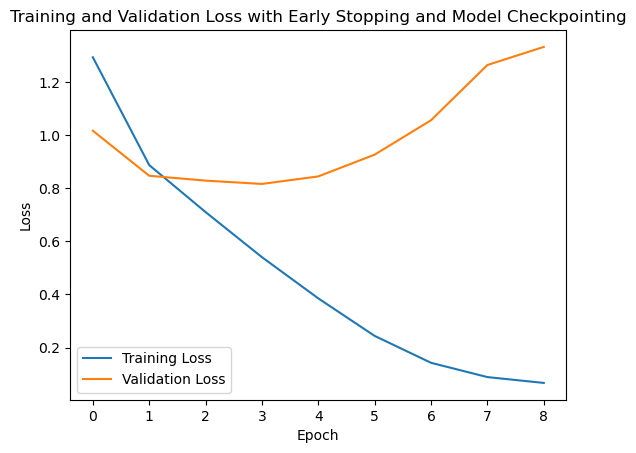

Best model loaded from checkpoint.


In [19]:
# Plot the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with Early Stopping and Model Checkpointing')
plt.show()

# Load the best model
net.load_state_dict(torch.load(checkpoint_path))
print("Best model loaded from checkpoint.")